# NC Assignment: Challenge for Data Scientist
This is the notebook I used to analyze the sample data provided by NC. Each step of the analysis is described below.

## Environment
The python environment for running this notebook has been setup in anaconda. The environment has been exported in a file called ```environment.yml```, which you can use to re-generate an exact copy of the working environment.

## Analysis

We start off by loading the input data into a pandas dataframe:

In [1]:
import pandas as pd

dataFilePath = '../../data/ncdatachallenge-2021-v1-1-.csv'

df = pd.read_csv(dataFilePath)

### First and second questions: probability and time of pregnancy
The goal is to answer the following questions:
1. What is the chance of getting pregnant within 13 cycles?
2. How long does it usually take to get pregnant?
   
To do so, I can focus on just two of the features that are available in the dataset: ```outcome``` and ```n_cycles_trying```. A quick check tells me that none of the two columns contain NaN values:

In [2]:
if df['outcome'].isna().any() == False:
    print(f'No NaN value in column outcome')
if df['n_cycles_trying'].isna().any() == False:
    print(f'No NaN value in column n_cycles_trying')

No NaN value in column outcome
No NaN value in column n_cycles_trying


This means I can use all the data contained in these columns.

In the following cell, I am going to build two histograms, representing the distributions of the time women take to attempt to conceive (in units of number of menstrual cycles). In one histogram I collect the data referring to women who eventually got pregnant, the other refers to women who did not get pregnant.

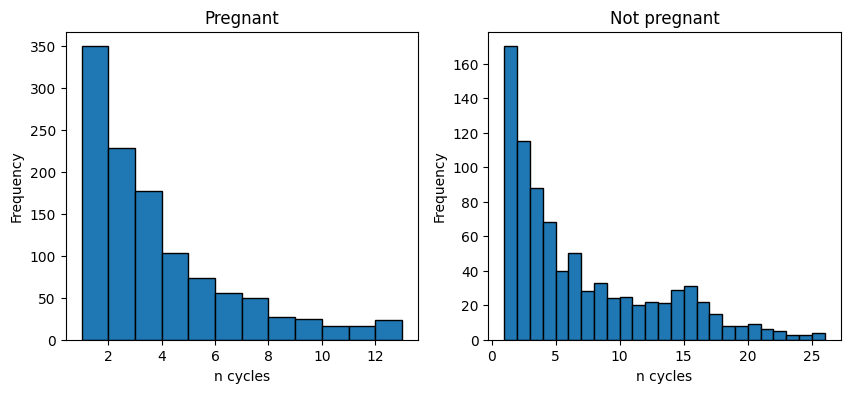

In [3]:
condition_pregnant = df['outcome'] == 'pregnant'
n_cycles_pregnant = df.loc[condition_pregnant, 'n_cycles_trying']

condition_not_pregnant = df['outcome'] == 'not_pregnant'
n_cycles_not_pregnant = df.loc[condition_not_pregnant, 'n_cycles_trying']

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].hist(n_cycles_pregnant, bins=range(min(n_cycles_pregnant), max(n_cycles_pregnant) + 1), edgecolor='black')
axes[0].set_xlabel('n cycles')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Pregnant')

axes[1].hist(n_cycles_not_pregnant, bins=range(min(n_cycles_not_pregnant), max(n_cycles_not_pregnant) + 1), edgecolor='black')
axes[1].set_xlabel('n cycles')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Not pregnant')

plt.show()

#### What is the chance of getting pregnant within 13 cycles?
The first question cannot be answered if formulated as such. The reason is that the dataset provided is biased: women who do not reach pregnancy stop trying to conceive and thus stop logging data at a *subjective point in time*. In many cases, we may safely assume that they resume contraception. To understand this more clearly, take a look at the right plot. It shows the distribution of the duration of the attempts to conceive for women who eventually did *not* get pregnant. The proper way to interpret this plot is as the distribution of the time it takes a woman to give up attempting. These data do not provide us with any quantitative handle for calculating probabilities, as they are the outcome of a subjective determination: we would never know whether a woman who stopped attempting would eventually have become pregnant at some point. In other words, we cannot calculate the probability of getting pregnant no-matter-what. 

More formally, what the question is asking is to calculate the conditional probability $P(pregnant|ncycles<13)$, for which one would need to use Bayes' theorem:
\begin{equation}
    P(pregnant|ncycles<13) = \frac{P(ncycles<13|pregnant)P(pregnant)}{P(ncycles<13)}
\end{equation}
However, $P(pregnant)$ cannot be calculated from the data, as just explained. Neither $P(ncycles<13)$: this would be the measurement of the occurrence of less than 13 cycles in an *unbiased* dataset. Thus, we cannot answer the question *as it is*.

The only form of the question we can answer is "What is the chance of getting pregnant within 13 cycles, given that one eventually *does* get pregnant?" (namely, one never gives up attempting until conception is reached). This would correspond to the $P(ncycles<13|pregnant)$ term in Bayes' equation above, and can be deduced from the left plot. The histogram shows that this chance is 100\%: of all women who eventually got pregnant, the duration of the attempt had been less than 13 cycles.

#### How long does it usually take to get pregnant?

To answer this question, we refer again to the distribution of the number of cycles shown in the left plot above, the one referring to women who eventyally got pregnant. Assuming that the two subsamples (outcome=pregnant and outcome=not\_pregnant) are both well representative of the population, the shape of this distribution is unaffected by what happens to the other one (right plot, the distribution of n\_cycles for women who did not conceive), save for statistical fluctuations. As a consequence, we may interpret its momenta as quantitative information on the conception time. Let's calculate mean, rms and median:

In [4]:
import numpy as np

print(f'Mean time   = {n_cycles_pregnant.mean()} cycles')
print(f'Rms time    = {np.sqrt(n_cycles_pregnant.var())} cycles')
print(f'Median time = {n_cycles_pregnant.median()} cycles')

Mean time   = 3.3754355400696863 cycles
Rms time    = 2.733305078852373 cycles
Median time = 2.0 cycles


We may thus say that, upon using NC Plan Pregnancy, it takes an average of $3.4\pm2.7$ cycles to finally conceive. As the distribution is highly asymmetric, it is of great use to mention its median, whose value is $2.0$: for 50\% of women it takes less than 2 cycles to conceive.

### Third question: What factors impact the time it takes to get pregnant?

This question can be answered by studying the correlation of n\_cycles with the other variables of the dataset. In order to do so, the dataset needs some pre-processing, mainly to solve two issues:
1. Convert alphanumeric values to numbers
2. Deal with ```NaN``` values

#### Preprocessing
The dataset consists of variables of different type: integer numbers, floating point numbers, booleans and strings. As far as the last two are concerned (booleans and strings), in order to use them in a quantitative analysis, they must first be converted into numbers, according to some mapping.

I have two possibilities:
1. label encoding: each unique value taken by the variables of the dataset is mapped onto a cardinal number (or vector of numbers);
2. one-hot encoding: for each unique value taken by the variables, a new column is added to the dataset, whose entry is set to 1 when the corresponding value is present in the row, to 0 otherwise

The first case is useful when the values to encode have an inherent cardinality. For eample, a column named "color" could be mapped onto the corresponding RGB 3-vector. If this is not the case, label encoding the data could actually be harmful, as it introduces a metric into the data which could result in unwanted artifacts.

For this dataset, none of the textual variables have an inherent cardinality, therefore the best choice is one-hot encoding. However, before carrying it out, I will actually make use of label encoding on a first stage, as I will use it to handle the ```NaN``` values that are present in the data.

The following block label-encodes the textual variables:

In [5]:
from sklearn.preprocessing import LabelEncoder

alphanumerical_columns = ['country', 'been_pregnant_before', 'education', 'sleeping_pattern', 'outcome', 'regular_cycle']

label_encoder = list()
for column in alphanumerical_columns:
    new_label_encoder = LabelEncoder()
    df[column] = new_label_encoder.fit_transform(df[column])
    label_encoder.append(new_label_encoder)

for i in range(len(label_encoder)):    
    print(f'{alphanumerical_columns[i]}: {label_encoder[i].classes_}')

country: ['AE' 'AO' 'AR' 'AT' 'AU' 'BE' 'BR' 'CA' 'CH' 'CL' 'DE' 'DK' 'EE' 'ES'
 'FI' 'FO' 'FR' 'GB' 'HU' 'IE' 'IL' 'IS' 'KE' 'MT' 'MY' 'NL' 'NO' 'NZ'
 'PL' 'PT' 'SE' 'SI' 'US' 'ZA' nan]
been_pregnant_before: ['No, never' 'Yes 3 times or more' 'Yes, once' 'Yes, twice' nan]
education: ['Elementary school' 'High school' 'PhD'
 'Trade/technical/vocational training' 'University' nan]
sleeping_pattern: ['Late and snoozer' 'Several times during the night' 'Shift worker'
 'Wake same every day' 'Wake same every workday' nan]
outcome: ['not_pregnant' 'pregnant']
regular_cycle: [False True nan]


The output shows that, for each of the slected columns, each unique value is mapped to an integer number (the index of its position in the classes vector). It also shows that ```NaN``` values are always set to the last index. I will make use of this feature.

Now that all boolean- and string-typed features have been mapped to numbers, let's take a look at the distribution of each variable:

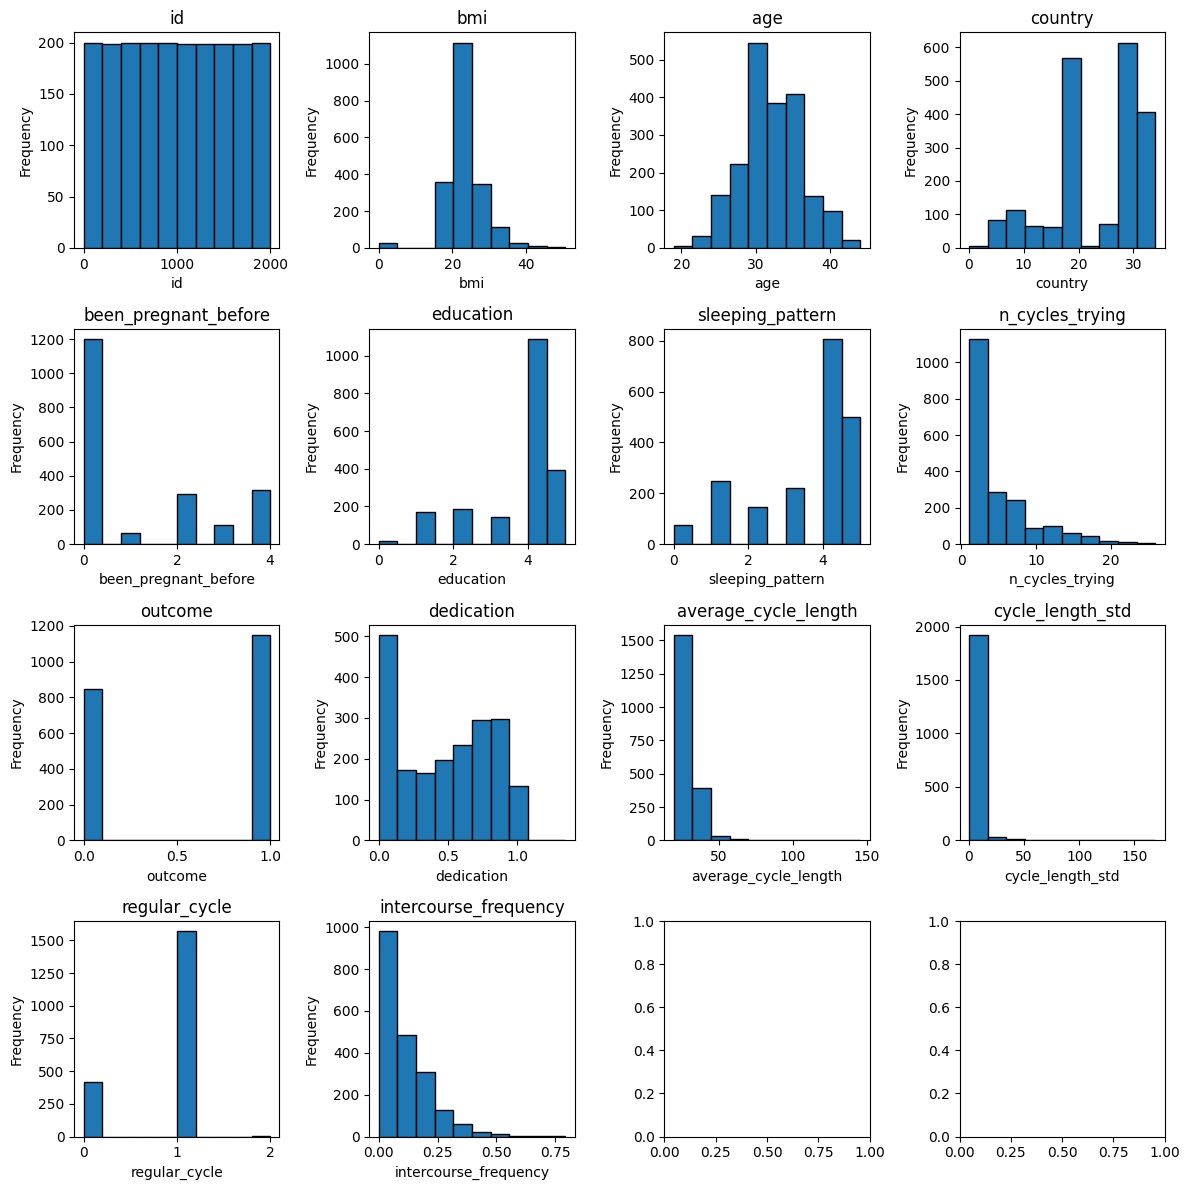

In [6]:
def plot_feature_distributions(df):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
    axes = axes.flatten()
    for i in range(14):
        axes[i].hist(df[df.columns[i]].dropna(), bins=10, edgecolor='black')
        axes[i].set_title(df.columns[i])
        axes[i].set_xlabel(df.columns[i])
        axes[i].set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()

plot_feature_distributions(df)

As the label encoding algorithm has mapped also the ```NaN``` values, these show up in the distributions of all the features that use to be textual. In these cases, we map the mapped values back to ```NaN```:

In [7]:
'''
Reinserting NaN's
'''

for i in range(len(label_encoder)):    
    nan_index = len(label_encoder[i].classes_)-1
    value = label_encoder[i].classes_[nan_index]
    if isinstance(value, float):
        df.loc[df[alphanumerical_columns[i]] == nan_index, alphanumerical_columns[i]] = np.nan

This allows us, in a moment, to handle all the ```NaN``` values present in the dataset, independently of the original type of the feature (integer, float, string or bool). 

Let's take a look at how often each feature is ```NaN```:

In [8]:
nan_counts = df.isna().sum()
print("NaN counts in each column:")
print(nan_counts)

NaN counts in each column:
id                         0
bmi                        0
age                        0
country                  113
been_pregnant_before     317
education                391
sleeping_pattern         499
n_cycles_trying            0
outcome                    0
dedication                 0
average_cycle_length       6
cycle_length_std          25
regular_cycle              6
intercourse_frequency      0
dtype: int64


There are different ways one can deal with ```NaN``` values. The most straightforward solution would be to eliminate a full row each time a ```NaN``` value occurs in any of the columns. This method is effective, but implies a reduction of the useful data. In the case of this dataset, we would give up *at least* 499/2000 entries, that is 1/4 of the data.

For this assignment, I decided to assign a random value to each occurrence of ```NaN```. For a given featrure, the random value is picked from the distribution of the feature itself (```NaN``` excluded, obviously...). This means that the distribution of the feature (i.e. the histogram plotted above) is used as the probability density function from which the random number is drawn. This method has the advantage that no statistics is lost: the dataset remains the same size as before. At the same time, the features maintain their statistical structure (as the random values substituting the ```NaN```'s are drawn from their own probability distribution) and no artificial correlations are introduced (as the new values are drawn randomly and independently from themselves and the other features).

The following block performs this task:

In [9]:
'''
Substituting NaN's with statistical sample
'''

for column in df.columns:
    value_counts = df[column].dropna().value_counts()
    values = value_counts.index
    probabilities = value_counts / value_counts.sum()
    random_number = np.random.choice(values, p=probabilities)
    df.loc[np.isnan(df[column]), column] = random_number

As a visual check, let's plot again the distribution of the features:

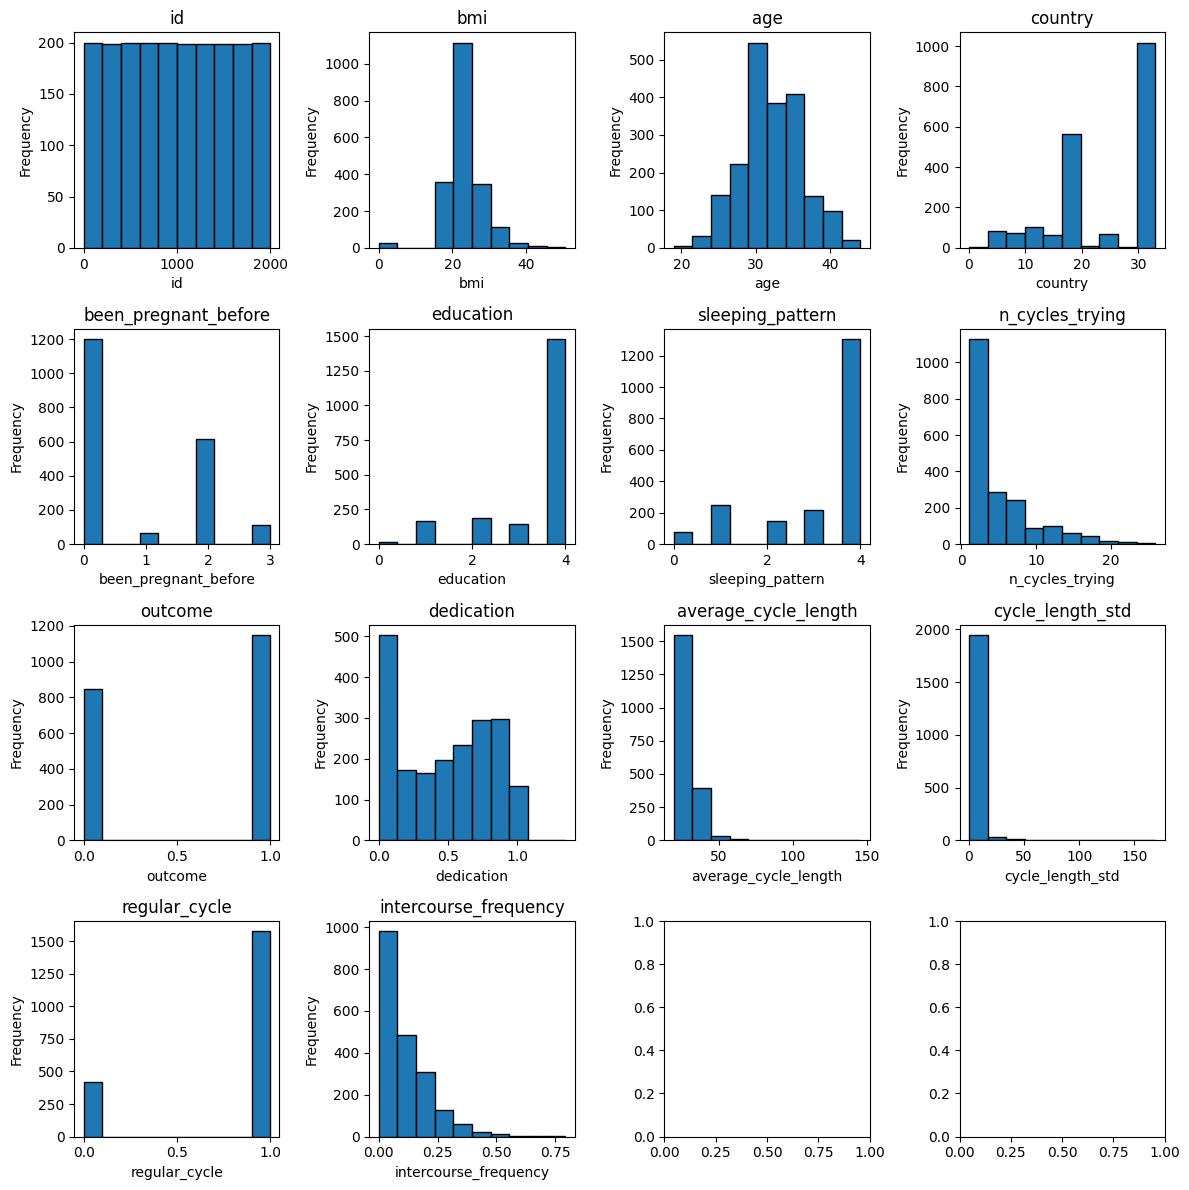

In [10]:
plot_feature_distributions(df)

A quick visual comparison with the previous ones shows that the statistical structure of the variables has remained identical (keep in mind that the previous plots also contained the values that mapped the ```NaN```'s).

We are finally ready to one-hot encode the features that we temporarily label-encoded:

In [11]:
for column in alphanumerical_columns:
    df = pd.get_dummies(df, columns=[column], prefix=column)

print(df)

        id        bmi  age  n_cycles_trying  dedication  average_cycle_length  \
0        0  22.942130   31                1    0.640000             25.588235   
1        1  19.886054   34                7    0.009569             30.875000   
2        2  29.323049   41                4    0.298246             27.666667   
3        3  24.386526   27                2    0.895833             24.250000   
4        4  29.299971   29                2    0.666667             25.466667   
...    ...        ...  ...              ...         ...                   ...   
1990  1996  24.867781   36                1    0.000000             30.250000   
1991  1997  21.616406   32                2    0.843750             31.166667   
1992  1998  24.218750   23               20    0.540187             26.629630   
1993  1999  21.453574   30                1    0.000000             38.600000   
1994  2000  19.948690   29                2    0.779661             29.909091   

      cycle_length_std  int

As we can see from the printout of the modified dataframe, new columns have been added, whose name is formatted as ```featureName_uniqueValue```. These columns are one-hot encoding the unique values of the corresponding feature.

#### Studying correlations
We are now ready to calculate the correlations between each variable. As we are interested in finding out which variables influence the time it takes to get pregnant (```n_cycles_trying```), for the reasons explained at the beginning we restrict the dataset to just those cases where pregnancy is actually reached (```outcome_1==1```) in the one-hot encoded dataset):

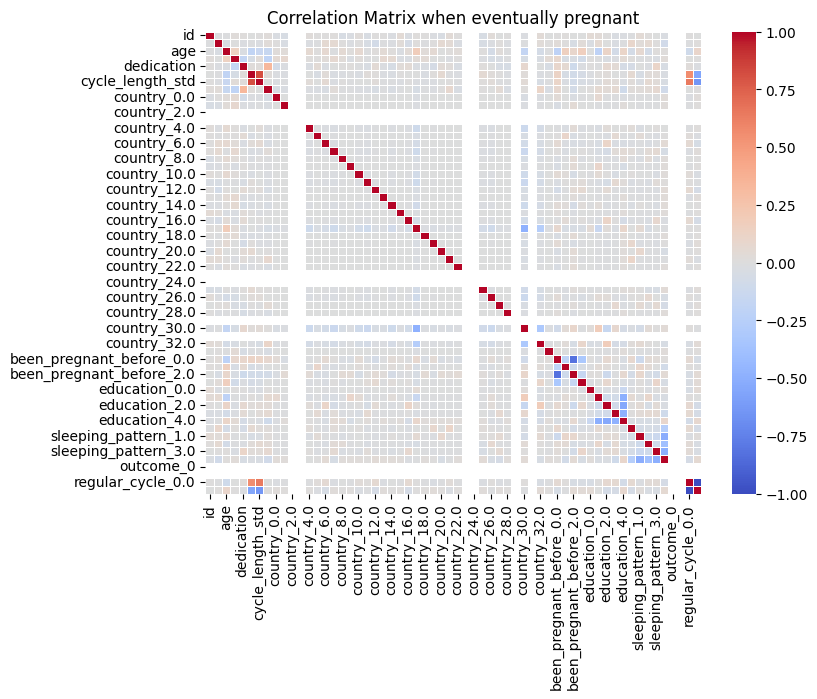

In [18]:
import seaborn as sns

condition = df['outcome_1'] == 1
df_pregnant = df[condition]

correlation_matrix = df_pregnant.corr()

def draw_correlation_matrix(corr_m, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_m, annot=False, cmap='coolwarm', linewidths=.5)    
    plt.title(title)
    plt.show()

draw_correlation_matrix(correlation_matrix, 'Correlation Matrix when eventually pregnant')

Empty entries in the correlation matrix are due to missing data for specific features (as a result of the dataset reduction upon imposing ```outcome_1==1```) or to variables with zero variance (notably, ```outcome_1```).

For the sake of tidyness, I'm going to plot the correlation matrix after removing the country columns from the dataset, as we will soon find out that they show no significant correlation with ```n_cycles_trying```:

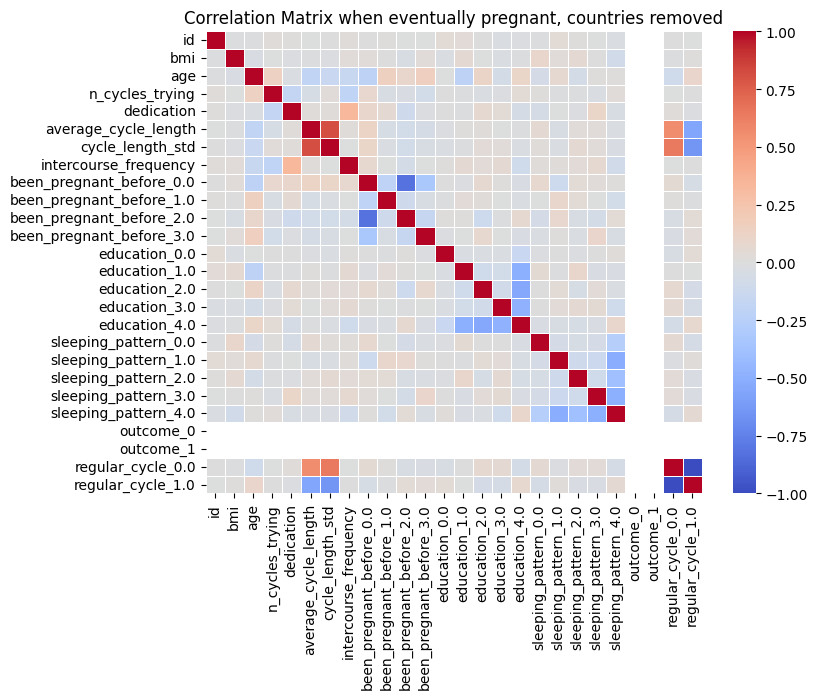

In [19]:
regex_to_exclude = 'country*'
filtered_df = df_pregnant.filter(regex=f'^(?!{regex_to_exclude}).*$', axis=1)

filtered_correlation_matrix = filtered_df.corr()

draw_correlation_matrix(filtered_correlation_matrix, 'Correlation Matrix when eventually pregnant, countries removed')

Let's print the correlation coefficients for ```n_cycles_trying```:

In [21]:
print(correlation_matrix['n_cycles_trying'])

id                          0.019999
bmi                        -0.006395
age                         0.133541
n_cycles_trying             1.000000
dedication                 -0.176147
average_cycle_length       -0.048052
cycle_length_std            0.025608
intercourse_frequency      -0.195324
country_0.0                 0.047776
country_1.0                 0.071594
country_2.0                      NaN
country_3.0                      NaN
country_4.0                 0.012419
country_5.0                 0.005456
country_6.0                 0.024465
country_7.0                 0.064133
country_8.0                 0.029645
country_9.0                -0.025672
country_10.0                0.021153
country_11.0               -0.008520
country_12.0               -0.000789
country_13.0                0.063067
country_14.0                0.059755
country_15.0               -0.025672
country_16.0               -0.026663
country_17.0                0.037304
country_18.0                0.039172
c

Let's set a threshold of 0.1 (absolute) to mark whether a correlation is significant or not. The following block shows the correlation coefficients that are selected by applying this threshold:

In [22]:
threshold = 0.1

corr = correlation_matrix['n_cycles_trying']
print(f'Positive correlations:\n{corr[corr>+threshold]}')
print(f'Negative correlations:\n{corr[corr<-threshold]}')

Positive correlations:
age                0.133541
n_cycles_trying    1.000000
Name: n_cycles_trying, dtype: float64
Negative correlations:
dedication              -0.176147
intercourse_frequency   -0.195324
Name: n_cycles_trying, dtype: float64


We conclude that the time it takes to get pregnant
1. increases with age
2. decreases with dedication and intercourse frequency (two variables which, by the way, are significantly correlated, as it is also intuitive to expect)